In [1]:
#import basic nessecities

import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import random
from tqdm.notebook import tqdm
from easydict import EasyDict
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
attributes = {
            "gpu": True,
            "batch_size": 128,
            "lr": 1e-3,
            "num_epochs": 50,
            "start_epoch": 1,
            "summary_interval" : 5,
            "weight_interval" : 10, 
            "weight_dir" : "/content/VAE_weights",
            "summary_dir": "/content/VAE_summary"
            }

args = EasyDict(attributes)

device = torch.device("cuda" if (args.gpu and torch.cuda.is_available()) else "cpu")
print(f"Device is {device}")

Device is cuda


# Model

In [3]:
class VAE(nn.Module):
    def __init__(self, imgChannels = 1, featureDim = 32*20*20, zDim = 256):
        super(VAE, self).__init__()

        #Encoder
        self.En_Conv1 = nn.Conv2d(imgChannels, 16, 5)
        self.En_Conv2 = nn.Conv2d(16, 32, 5)
        self.En_fc1 = nn.Linear(featureDim, zDim)
        self.En_fc2 = nn.Linear(featureDim, zDim)

        #Decoder
        self.De_FC1 = nn.Linear(zDim, featureDim)
        self.Dec_ConvT1 = nn.ConvTranspose2d(32, 16, 5)
        self.Dec_ConvT2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x):

        x = F.relu(self.En_Conv1(x))
        x = F.relu(self.En_Conv2(x))
        x = x.view(-1, 32*20*20)

        mu = self.En_fc1(x)
        logVar = self.En_fc2(x)

        return mu, logVar

    def reparametrization(self, mu, logVar):

        std = torch.exp(logVar/2)
        eps = torch.rand_like(std)

        return mu + (eps*std)     

    def decoder(self, z):
        z = F.relu(self.De_FC1(z))
        z = z.view(-1, 32,20,20)
        z = F.relu(self.Dec_ConvT1(z))
        z = torch.sigmoid(self.Dec_ConvT2(z))

        # z = torch.sigmoid(self.Dec_ConvT2(z))

        return z

    def forward(self, x:torch.Tensor):

        mu, logVar = self.encoder(x)
        z = self.reparametrization(mu, logVar)
        out = self.decoder(z)

        return z,mu,logVar,out

# Data 

In [4]:
from torchvision import datasets, transforms

train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train = True, download = True, transform= transforms.ToTensor()), batch_size= args.batch_size)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train = False, transform= transforms.ToTensor()), batch_size= args.batch_size)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
#Dataloader shapes

train_X, train_y = next(iter(train_loader))
print("Shape of train_X is: ", train_X.size())
print("Shape of train_y is: ", train_y.size())

Shape of train_X is:  torch.Size([128, 1, 28, 28])
Shape of train_y is:  torch.Size([128])


In [6]:
#Visualize some random datapoints

def display_sample_images(data_batch, image_counts = 5, is_rgb = False):

    batch_X, batch_y = data_batch

    plt.figure(figsize= (10,10))
    for i in range(1, image_counts+1):
        index = random.randint(0, len(batch_X)-1)
        
        plt.subplot(1, 5, i)
        plt.imshow(tensor2numpy(batch_X[index]))
        plt.title("Number: " + str(batch_y[index].item()))

def tensor2numpy(tensor_image, is_rgb = False):
    img = tensor_image.permute(1,2,0).numpy()
    img = img.squeeze(-1)
    return img


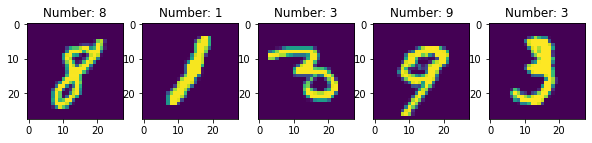

In [7]:
display_sample_images(next(iter(train_loader)))

# Loss Functions

In [8]:
class KLD_Loss(nn.Module):
    def __init__(self, weight: float = 1.):
        super(KLD_Loss, self).__init__()
        self.weight = weight

    def forward(self, output_mu, output_logVar):
        batch_size = output_mu.size(0)
        # output_mu = output_mu
        # output_logVar = output_logVar
        
        KL_loss = 0.5* (torch.sum(-1 - output_logVar + torch.pow(output_mu, 2) + torch.exp(output_logVar)))
        return self.weight * KL_loss

# Main

In [9]:
#Initialize the model, optimizer, loss functions
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = args.lr)

kld_criterion = KLD_Loss().to(device)
mse_criterion = nn.MSELoss(reduction= "sum").to(device)

In [10]:
track_dict = {
        "Epoch": [],
        "Tr_MSE_Loss": [],
        "Tr_KLD_Loss": [],
        "Training_Loss": [],
        "Te_MSE_Loss": [],
        "Te_KLD_Loss": [],
        "Test_Loss": []
            }

In [11]:
def train(model, train_loader, device, epoch_id, args, track_dict):
    model.train()
    train_loss = 0
    train_kld = 0
    train_mse = 0

    for data in tqdm(train_loader):
        optimizer.zero_grad()

        #getting the data
        data_X, _ = data
        data_X = data_X.to(device)

        
        #forward_propagation
        _,mu,logVar, reconstructed_op = model(data_X)
        mse_loss = mse_criterion(reconstructed_op, data_X)
        kld_loss = kld_criterion(mu, logVar)
        loss = mse_loss + kld_loss

        #back_propagation
        loss.backward()
        optimizer.step()

        #getting the losses for record_keeping
        train_mse += mse_loss.item()
        train_kld += kld_loss.item()
        train_loss += loss.item()


    train_loss /= len(train_loader.dataset)
    train_mse /= len(train_loader.dataset)
    train_kld /= len(train_loader.dataset)
    
    #Updating the tracker
    track_dict["Epoch"].append(epoch_id)
    track_dict["Tr_MSE_Loss"].append(train_mse)
    track_dict["Tr_KLD_Loss"].append(train_kld)
    track_dict["Training_Loss"].append(train_loss)

    print("Epoch {}/{}: Training_Loss {:.6f}, MSE_Loss {:.6f}, KLD_Loss {:.6f}".format(epoch_id, args.num_epochs, train_loss, train_mse, train_kld))

In [12]:
def test(model, test_loader, device, epoch_id, args, track_dict):
    model.eval()
    test_loss = 0
    test_kld = 0
    test_mse = 0 

    with torch.no_grad():
        for data in tqdm(test_loader):
            data_X, _ = data
            data_X = data_X.to(device)

            #forward prop
            _,mu,logVar, reconstructed_op = model(data_X)
            mse_loss = mse_criterion(reconstructed_op, data_X)
            kld_loss = kld_criterion(mu, logVar)
            loss = mse_loss + kld_loss         

            #Updating the loss
            test_loss += loss.item()
            test_kld += kld_loss.item()
            test_mse += mse_loss.item()

    test_loss /= len(test_loader.dataset)
    test_kld /= len(test_loader.dataset)
    test_mse /= len(test_loader.dataset)

    #updating the track_dict
    track_dict["Te_MSE_Loss"].append(test_mse)
    track_dict["Te_KLD_Loss"].append(test_kld)
    track_dict["Test_Loss"].append(test_loss)

    print("Epoch {}/{}: Test_Loss {:.6f}, MSE_Loss {:.6f}, KLD_Loss {:.6f}".format(epoch_id, args.num_epochs, test_loss, test_mse, test_kld))

In [ ]:
for epoch_id in range(args.start_epoch, args.num_epochs+1):
    train(net, train_loader, device, epoch_id, args, track_dict)
    test(net, test_loader, device, epoch_id, args, track_dict)

    #Create a path for storing weights & summary
    if not os.path.isdir(args.weight_dir):
        os.mkdir(args.weight_dir)
    if not os.path.isdir(args.summary_dir):
        os.mkdir(args.summary_dir)

    #Saving summary & weights
    if epoch_id % args.summary_interval == 0:
        pd.DataFrame(track_dict).to_csv(args.summary_dir +"/" + "summary.csv")

    if epoch_id % args.weight_interval == 0:
        torch.save(net.state_dict(), args.weight_dir + "/" + "VAE_epoch" + str(epoch_id) + ".pth")


Epoch 1/50: Training_Loss 14.569513, MSE_Loss 8.767507, KLD_Loss 5.802006



Epoch 1/50: Test_Loss 14.685878, MSE_Loss 8.978157, KLD_Loss 5.707720



Epoch 2/50: Training_Loss 14.457652, MSE_Loss 8.661139, KLD_Loss 5.796513



Epoch 2/50: Test_Loss 14.464408, MSE_Loss 8.744950, KLD_Loss 5.719458



Epoch 3/50: Training_Loss 14.308611, MSE_Loss 8.520653, KLD_Loss 5.787958



Epoch 3/50: Test_Loss 14.312382, MSE_Loss 8.537103, KLD_Loss 5.775279



Epoch 4/50: Training_Loss 14.206321, MSE_Loss 8.433636, KLD_Loss 5.772685



Epoch 4/50: Test_Loss 14.255811, MSE_Loss 8.552831, KLD_Loss 5.702980



Epoch 5/50: Training_Loss 14.111760, MSE_Loss 8.349566, KLD_Loss 5.762194



Epoch 5/50: Test_Loss 14.068816, MSE_Loss 8.471767, KLD_Loss 5.597049



Epoch 6/50: Training_Loss 14.025540, MSE_Loss 8.267394, KLD_Loss 5.758146



Epoch 6/50: Test_Loss 14.094119, MSE_Loss 8.399398, KLD_Loss 5.694721



Epoch 7/50: Training_Loss 13.947240, MSE_Loss 8.195927, KLD_Loss 5.751313



Epoch 7/50: Test_Loss 13.958276, MSE_Loss 8.382484, KLD_Loss 5.575792



Epoch 8/50: Training_Loss 13.872594, MSE_Loss 8.134981, KLD_Loss 5.737614



Epoch 8/50: Test_Loss 13.909067, MSE_Loss 8.069004, KLD_Loss 5.840063



Epoch 9/50: Training_Loss 13.811426, MSE_Loss 8.080981, KLD_Loss 5.730445



Epoch 9/50: Test_Loss 14.078259, MSE_Loss 8.341916, KLD_Loss 5.736343



Epoch 10/50: Training_Loss 13.729082, MSE_Loss 8.002923, KLD_Loss 5.726159



Epoch 10/50: Test_Loss 13.714943, MSE_Loss 8.008259, KLD_Loss 5.706683



Epoch 11/50: Training_Loss 13.666528, MSE_Loss 7.944133, KLD_Loss 5.722395



Epoch 11/50: Test_Loss 13.905384, MSE_Loss 8.592291, KLD_Loss 5.313093



Epoch 12/50: Training_Loss 13.629856, MSE_Loss 7.905999, KLD_Loss 5.723856



Epoch 12/50: Test_Loss 14.364896, MSE_Loss 9.191747, KLD_Loss 5.173149



Epoch 13/50: Training_Loss 13.571599, MSE_Loss 7.855801, KLD_Loss 5.715798



Epoch 13/50: Test_Loss 13.789940, MSE_Loss 8.168348, KLD_Loss 5.621593



Epoch 14/50: Training_Loss 13.506744, MSE_Loss 7.803330, KLD_Loss 5.703414



Epoch 14/50: Test_Loss 13.622104, MSE_Loss 8.118327, KLD_Loss 5.503777



Epoch 15/50: Training_Loss 13.471365, MSE_Loss 7.766765, KLD_Loss 5.704600



Epoch 15/50: Test_Loss 13.460270, MSE_Loss 7.917233, KLD_Loss 5.543037



Epoch 16/50: Training_Loss 13.405883, MSE_Loss 7.711008, KLD_Loss 5.694875



Epoch 16/50: Test_Loss 13.697966, MSE_Loss 8.402802, KLD_Loss 5.295163



Epoch 17/50: Training_Loss 13.386138, MSE_Loss 7.689413, KLD_Loss 5.696725



Epoch 17/50: Test_Loss 13.499516, MSE_Loss 8.059312, KLD_Loss 5.440204



Epoch 18/50: Training_Loss 13.343115, MSE_Loss 7.648109, KLD_Loss 5.695006



Epoch 18/50: Test_Loss 13.476129, MSE_Loss 8.166394, KLD_Loss 5.309735



Epoch 19/50: Training_Loss 13.307890, MSE_Loss 7.626239, KLD_Loss 5.681651



Epoch 19/50: Test_Loss 13.633672, MSE_Loss 8.288315, KLD_Loss 5.345357



Epoch 20/50: Training_Loss 13.220988, MSE_Loss 7.558842, KLD_Loss 5.662146



Epoch 20/50: Test_Loss 13.339293, MSE_Loss 7.917066, KLD_Loss 5.422227



Epoch 21/50: Training_Loss 13.222386, MSE_Loss 7.542164, KLD_Loss 5.680223



Epoch 21/50: Test_Loss 13.409121, MSE_Loss 8.042039, KLD_Loss 5.367082



Epoch 22/50: Training_Loss 13.196197, MSE_Loss 7.517435, KLD_Loss 5.678762



Epoch 22/50: Test_Loss 13.425687, MSE_Loss 8.082156, KLD_Loss 5.343531



Epoch 23/50: Training_Loss 13.162428, MSE_Loss 7.489786, KLD_Loss 5.672642



Epoch 23/50: Test_Loss 13.312959, MSE_Loss 7.883417, KLD_Loss 5.429542



Epoch 24/50: Training_Loss 13.134686, MSE_Loss 7.461032, KLD_Loss 5.673654



Epoch 24/50: Test_Loss 13.439613, MSE_Loss 8.023374, KLD_Loss 5.416239



Epoch 25/50: Training_Loss 13.089670, MSE_Loss 7.426807, KLD_Loss 5.662862



Epoch 25/50: Test_Loss 13.238624, MSE_Loss 7.759506, KLD_Loss 5.479118



Epoch 26/50: Training_Loss 13.086118, MSE_Loss 7.411585, KLD_Loss 5.674533



Epoch 26/50: Test_Loss 13.208970, MSE_Loss 7.512459, KLD_Loss 5.696512



Epoch 27/50: Training_Loss 13.042556, MSE_Loss 7.382933, KLD_Loss 5.659623



Epoch 27/50: Test_Loss 13.103572, MSE_Loss 7.688566, KLD_Loss 5.415006



Epoch 28/50: Training_Loss 13.009062, MSE_Loss 7.345578, KLD_Loss 5.663484



Epoch 28/50: Test_Loss 13.217320, MSE_Loss 7.961430, KLD_Loss 5.255891



Epoch 29/50: Training_Loss 12.985828, MSE_Loss 7.326859, KLD_Loss 5.658969



Epoch 29/50: Test_Loss 13.163945, MSE_Loss 7.792177, KLD_Loss 5.371768



Epoch 30/50: Training_Loss 12.961045, MSE_Loss 7.306892, KLD_Loss 5.654153



Epoch 30/50: Test_Loss 13.144325, MSE_Loss 7.711288, KLD_Loss 5.433037



Epoch 31/50: Training_Loss 12.940436, MSE_Loss 7.285226, KLD_Loss 5.655210



Epoch 31/50: Test_Loss 13.194588, MSE_Loss 7.842771, KLD_Loss 5.351817



Epoch 32/50: Training_Loss 12.919261, MSE_Loss 7.274556, KLD_Loss 5.644705



Epoch 32/50: Test_Loss 12.993559, MSE_Loss 7.512429, KLD_Loss 5.481130



Epoch 33/50: Training_Loss 12.892152, MSE_Loss 7.241060, KLD_Loss 5.651092



Epoch 33/50: Test_Loss 13.113728, MSE_Loss 7.579722, KLD_Loss 5.534007



Epoch 34/50: Training_Loss 12.890066, MSE_Loss 7.236808, KLD_Loss 5.653258



Epoch 34/50: Test_Loss 12.976803, MSE_Loss 7.640967, KLD_Loss 5.335836



Epoch 35/50: Training_Loss 12.852803, MSE_Loss 7.211180, KLD_Loss 5.641623



Epoch 35/50: Test_Loss 12.953531, MSE_Loss 7.564727, KLD_Loss 5.388805



Epoch 36/50: Training_Loss 12.827147, MSE_Loss 7.186920, KLD_Loss 5.640228



Epoch 36/50: Test_Loss 12.899629, MSE_Loss 7.492515, KLD_Loss 5.407115



Epoch 37/50: Training_Loss 12.823157, MSE_Loss 7.178859, KLD_Loss 5.644299



Epoch 37/50: Test_Loss 12.951370, MSE_Loss 7.480738, KLD_Loss 5.470632



Epoch 38/50: Training_Loss 12.804400, MSE_Loss 7.168188, KLD_Loss 5.636212



Epoch 38/50: Test_Loss 12.933165, MSE_Loss 7.349018, KLD_Loss 5.584147



Epoch 39/50: Training_Loss 12.780188, MSE_Loss 7.143973, KLD_Loss 5.636216



Epoch 39/50: Test_Loss 13.074588, MSE_Loss 7.828048, KLD_Loss 5.246539



Epoch 40/50: Training_Loss 12.752656, MSE_Loss 7.126393, KLD_Loss 5.626263



Epoch 40/50: Test_Loss 13.233140, MSE_Loss 7.888684, KLD_Loss 5.344456



Epoch 41/50: Training_Loss 12.745018, MSE_Loss 7.119831, KLD_Loss 5.625187



Epoch 41/50: Test_Loss 12.953959, MSE_Loss 7.295584, KLD_Loss 5.658375



Epoch 42/50: Training_Loss 12.738290, MSE_Loss 7.107811, KLD_Loss 5.630479



Epoch 42/50: Test_Loss 13.031276, MSE_Loss 7.858727, KLD_Loss 5.172550



Epoch 43/50: Training_Loss 12.709671, MSE_Loss 7.087610, KLD_Loss 5.622061



Epoch 43/50: Test_Loss 12.879815, MSE_Loss 7.510505, KLD_Loss 5.369309



Epoch 44/50: Training_Loss 12.699443, MSE_Loss 7.072649, KLD_Loss 5.626794



Epoch 44/50: Test_Loss 13.147734, MSE_Loss 7.765143, KLD_Loss 5.382590



Epoch 45/50: Training_Loss 12.685943, MSE_Loss 7.060409, KLD_Loss 5.625534



Epoch 45/50: Test_Loss 13.257674, MSE_Loss 7.699831, KLD_Loss 5.557844



Epoch 46/50: Training_Loss 12.688307, MSE_Loss 7.051939, KLD_Loss 5.636369



Epoch 46/50: Test_Loss 12.940614, MSE_Loss 7.413740, KLD_Loss 5.526874



Epoch 47/50: Training_Loss 12.648576, MSE_Loss 7.035518, KLD_Loss 5.613059



Epoch 47/50: Test_Loss 12.807340, MSE_Loss 7.547948, KLD_Loss 5.259392



Epoch 48/50: Training_Loss 12.634754, MSE_Loss 7.016421, KLD_Loss 5.618333



Epoch 48/50: Test_Loss 12.757229, MSE_Loss 7.441409, KLD_Loss 5.315820



Epoch 49/50: Training_Loss 12.638845, MSE_Loss 7.028387, KLD_Loss 5.610457



Epoch 49/50: Test_Loss 12.881836, MSE_Loss 7.859943, KLD_Loss 5.021893



Epoch 50/50: Training_Loss 12.640061, MSE_Loss 7.012832, KLD_Loss 5.627230



Epoch 50/50: Test_Loss 13.126576, MSE_Loss 7.868950, KLD_Loss 5.257626


# Plots

In [ ]:
path = "/content/VAE_summary/summary.csv"

df = pd.read_csv(path)
df.head(6)

,Unnamed: 0,Epoch,Tr_MSE_Loss,Tr_KLD_Loss,Training_Loss,Te_MSE_Loss,Te_KLD_Loss,Test_Loss
0,0,1,8.767507,5.802006,14.569513,8.978157,5.707720,14.685878
1,1,2,8.661139,5.796513,14.457652,8.744950,5.719458,14.464408
2,2,3,8.520653,5.787958,14.308611,8.537103,5.775279,14.312382
3,3,4,8.433636,5.772685,14.206321,8.552831,5.702980,14.255811
4,4,5,8.349566,5.762194,14.111760,8.471767,5.597049,14.068816
5,5,6,8.267394,5.758146,14.025540,8.399398,5.694721,14.094119


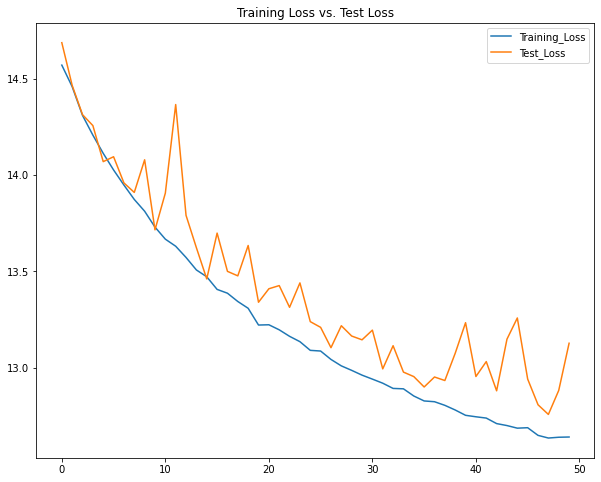

In [ ]:
### TrainLoss and TestLoss

plt.figure(figsize = (10,8))
plt.plot(df["Training_Loss"])
plt.plot(df["Test_Loss"])
plt.title("Training Loss vs. Test Loss")
plt.legend(["Training_Loss", "Test_Loss"])
plt.show()

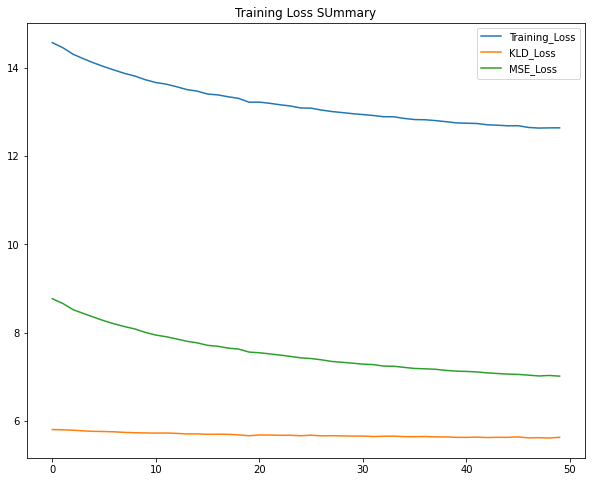

In [ ]:
### TrainLoss and TestLoss

plt.figure(figsize = (10,8))
plt.plot(df["Training_Loss"])
plt.plot(df["Tr_KLD_Loss"])
plt.plot(df["Tr_MSE_Loss"])
plt.title("Training Loss Summary")
plt.legend(["Training_Loss", "KLD_Loss", "MSE_Loss"])
plt.show()

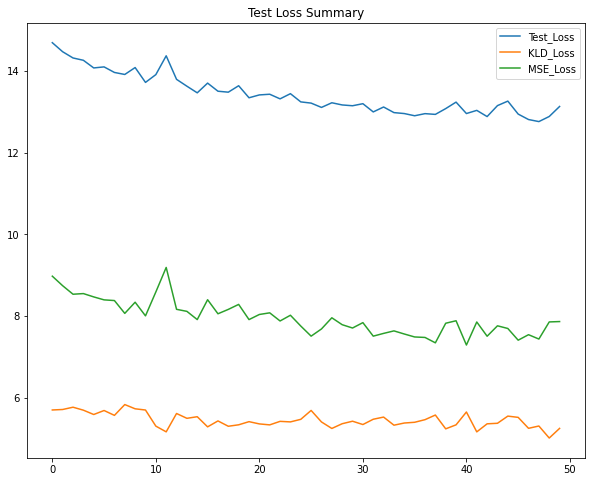

In [ ]:
### Test_Loss summary

plt.figure(figsize = (10,8))
plt.plot(df["Test_Loss"])
plt.plot(df["Te_KLD_Loss"])
plt.plot(df["Te_MSE_Loss"])
plt.title("Test Loss Summary")
plt.legend(["Test_Loss", "KLD_Loss", "MSE_Loss"])
plt.show()

# Test Time

In [13]:
#Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)

path2weight = "/content/VAE_epoch40.pth"
model.load_state_dict(torch.load(path2weight), strict = True)

<All keys matched successfully>

In [14]:
data_X,_ = next(iter(test_loader))
data_X.size()


def image_comparision(VAE_model, dataX):
    VAE_model.eval()

    index = random.randint(0, len(dataX)-1)
    img = dataX[index]

    with torch.no_grad():
        img = img.to(device)
        img = img.unsqueeze(0)      #NCHW format

        #Forward_Prop
        _, mu, logVar, reconstructed_img = VAE_model(img)
        
        #Get reconstructed Image numpy array
        reconstructed_img = reconstructed_img.squeeze(0).permute(1,2,0).to("cpu").numpy().squeeze(-1)
        img = img.squeeze(0).permute(1,2,0).to("cpu").numpy().squeeze(-1)

    plt.figure(figsize = (10,8))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(reconstructed_img)
    plt.title("Reconstructed Image")

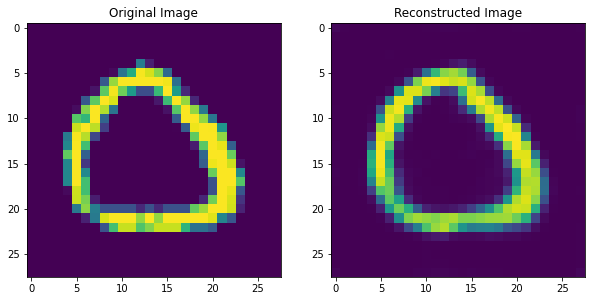

In [19]:
image_comparision(model, data_X)

#Visualizing the Latent Space - T-SNE

### Getting the latent data

In [20]:
#Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)

path2weight = "/content/VAE_epoch40.pth"
model.load_state_dict(torch.load(path2weight), strict = True)

<All keys matched successfully>

In [21]:
#Getting the hidden representation of the data

my_data = []
my_labels = []

model.eval()

with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)

        #Feedforward through the model
        z,mu,logVar,out = model(img)
        z = z.to("cpu").numpy()
        label = label.to("cpu").numpy()

        #Appending to the list
        my_data.append(z)
        my_labels.append(label)

print("Tasks done succesfully!")

Tasks done succesfully!


z is of dimension 128 * 256 i.e. each image is compressed to a vector of shape 256

In [22]:
data_X = np.concatenate(my_data)
print("Shape of data_X is: ", data_X.shape)

data_y = np.concatenate(my_labels)
print("Shape of data_y is: ", data_y.shape)

Shape of data_X is:  (10000, 256)
Shape of data_y is:  (10000,)


### T-SNE visualization

In [28]:
import seaborn as sns

In [23]:
from sklearn.manifold import TSNE
seed = 101

tsne = TSNE(n_components=2, random_state= seed)
transformed_data_X = tsne.fit_transform(data_X)

In [24]:
print("Shape of the transformed data is: ", transformed_data_X.shape)

Shape of the transformed data is:  (10000, 2)


In [25]:
#Saving the transformed data for future uses

transformed_data_X_df = pd.DataFrame(transformed_data_X, columns = ["Feature1", "Feature2"])
transformed_data_X_df["Labels"] = data_y

transformed_data_X_df.to_csv("Transformed_Test_Data.csv")

In [33]:
def TSNE_plot(X1, X2, targets, title):
    '''
    X1: Numpy array
    X2: Numpy array
    targets: Array containing the labels
    title: Plot heading
    '''
    plt.figure(figsize= (10,8))
    sns.scatterplot(x = X1, y = X2, hue = targets, palette = "Set3")
    plt.title("T-SNE decomposition of the data")
    plt.show()

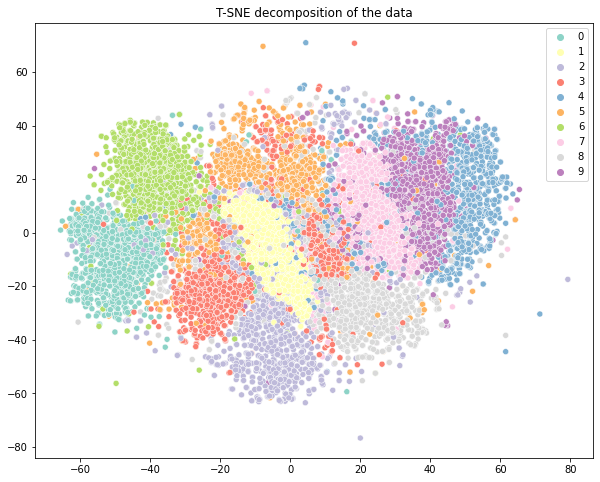

In [34]:
#Getting the plot
TSNE_plot(transformed_data_X[:,0], transformed_data_X[:,1], data_y, "T-SNE plot of the enocoded data")